# Udacity SDC Lesson 2 (Finding Lane)

## Coding up a Color Selection
Let’s code up a simple color selection in Python.
No need to download or install anything, you can just follow along in the browser for now.
We'll be working with the same image you saw previously.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

In [10]:
plt.ion() # don't need to call plt.show() every time

In [104]:
import sdc_utils;
from importlib import reload
reload(sdc_utils)
from sdc_utils import *

I then read in an image and print out some stats. I’ll grab the x and y sizes and make a copy of the image to work with. NOTE: Always make a copy of arrays or other variables in Python. If instead, you say "a = b" then all changes you make to "a" will be reflected in "b" as well!

This image is:  <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


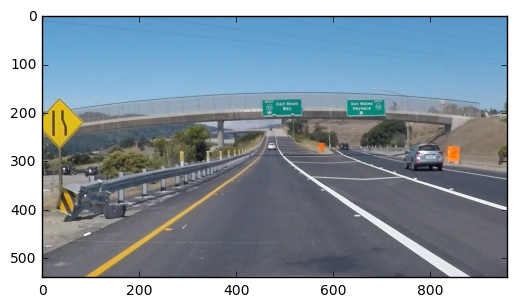

In [151]:
# Read in the image and print out some stats
#image = cv2.imread('data/l_yellow_r_white.jpg',cv2.IMREAD_UNCHANGED)
#image = cv2.imread('data/color_region1.jpg',cv2.IMREAD_UNCHANGED)
image = cv2.imread('data/exit-ramp.jpg',cv2.IMREAD_UNCHANGED)

image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print('This image is: ',type(image), 
         'with dimensions:', image.shape)

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
# Note: always make a copy rather than simply using "="
color_select = np.copy(image)
plt.imshow(image_RGB)

## Besides what I learned (detecting white lane), I need to use cv.inrange to detect yellow objects and still leave to method in the lesson to detect white lanes
For white lane, I followed what's in the lesson: define a color threshold in the variables <font color='red'>red_threshold</font>, <font color='red'>green_thresholdd</font>, and <font color='red'>blue_threshold</font> and populate <font color='red'>rgb_threshold</font> with these values. This vector contains the minimum values for red, green, and blue (R,G,B) that I will allow in my selection.


## Step 1: Using cv2.inrange() to detect yellow objects

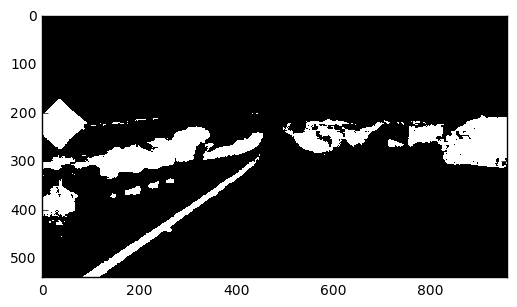

In [166]:
hsv_img = cv2.cvtColor(color_select, cv2.COLOR_BGR2HSV)
#black = np.zeros(color_select.shape)
# Two different range of yellow from Web
#  1
#  lower_yellow = numpy.array([ 50,  50, 170])
#  upper_yellow = numpy.array([255, 255, 190])
#  2
#  lower_yellow = numpy.array([ 10,  10,  10])
#  upper_yellow = numpy.array([255, 255, 250])
#  3
#  lower_yellow = numpy.array([ 20, 100, 100])
#  upper_yellow = numpy.array([30, 255, 255])
#  4
#  lower_yellow = numpy.array([15, 210, 20]);
#  upper_yellow = numpy.array([35, 255, 255]);

mask_yellow = cv2.inRange(hsv_img,np.array((10,30,30)),np.array((40,255,255)))

plt.imshow(mask_yellow,cmap='gray',  interpolation='nearest')
plt.show()


## Step 2: As learned in the lesson, detect white lane
Next, I'll select any pixels below the threshold and set them to zero.

After that, all pixels that meet my color criterion (those above the threshold) will be retained, and those that do not (below the threshold) will be blacked out.

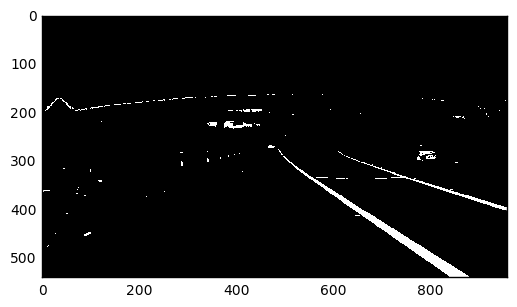

In [167]:
#white_in_image = getWhiteInImage(image)
sensitivity=60
mask_white = cv2.inRange(hsv_img,np.array((0,0,255-sensitivity)),np.array((255,sensitivity,255)))
plt.imshow(mask_white,cmap='gray',  interpolation='nearest')
plt.show()

## Step 3: Canny Edge Detection in Action
Now that you have a conceptual grasp on how the Canny algorithm works, it's time to use it to find the edges of the lane lines in an image of the road. So let's give that a try.

First, we need to read in an image:

Here we have an image of the road, and it's fairly obvious by eye where the lane lines are, but what about using computer vision?

Let's go ahead and convert to grayscale.

### Step 3.1 Convert to grey image

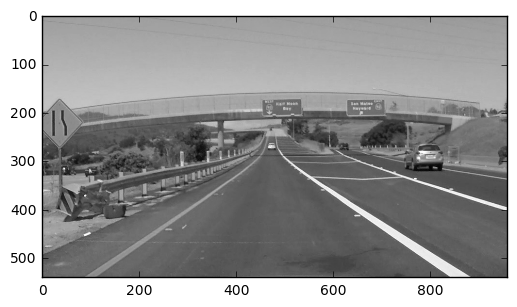

In [168]:
gray = grayscale(image) #grayscale conversion
plt.imshow(gray, cmap='gray')

### Step3.2：Edge detection
#### (Apply Gaussian smoothing / blurring and Canny function)

This is where OpenCV gets useful. First, we'll have a look at the parameters for the OpenCV <font color="red">Canny</font> function. 

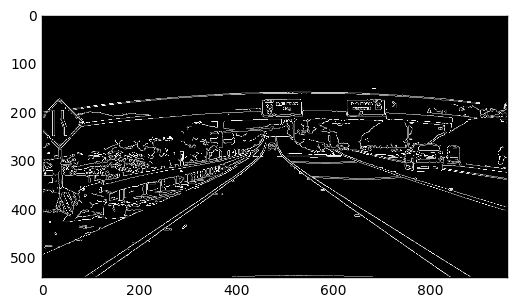

In [169]:
# Define a kernel size for Gaussian smoothing / blurring
kernel_size = 3 # Must be an odd number (3, 5, 7...)
blur_gray = gaussian_blur(gray,kernel_size)

# Define our parameters for Canny and run it
low_threshold = 80
high_threshold = 160
edges = canny(image_RGB, low_threshold, high_threshold)

# Display the image
plt.imshow(edges, cmap='Greys_r')


### Step 3.3 Using the Hough Transform to Find Lines from Canny Edges

## Implementing a Hough Transform on Edge Detected Image
Now you know how the Hough Transform works, but to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.).

To do this, we'll be using an OpenCV function called <font color="red">HoughLinesP</font> that takes several parameters. Let's code it up and find the lane lines in the image we detected edges in with the Canny function (for a look at coding up a Hough Transform from scratch, check [this](https://alyssaq.github.io/2014/understanding-hough-transform/) out.) .

Here's the image we're working with:

Let's look at the input parameters for the OpenCV function <font color="red">HoughLinesP</font> that we will use to find lines in the image. You will call it like this:

'\n# Create a "color" binary image to combine with line image\ncolor_edges = np.dstack((edges, edges, edges)) \n# Draw the lines on the edge image\nlines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) \n\nfig = plt.figure(figsize=(18, 18))\nplt.subplot(1,3,1)\nplt.imshow(color_edges)\nplt.subplot(1,3,2)\nplt.imshow(line_image)\nplt.subplot(1,3,3)\nplt.imshow(lines_edges)\n'

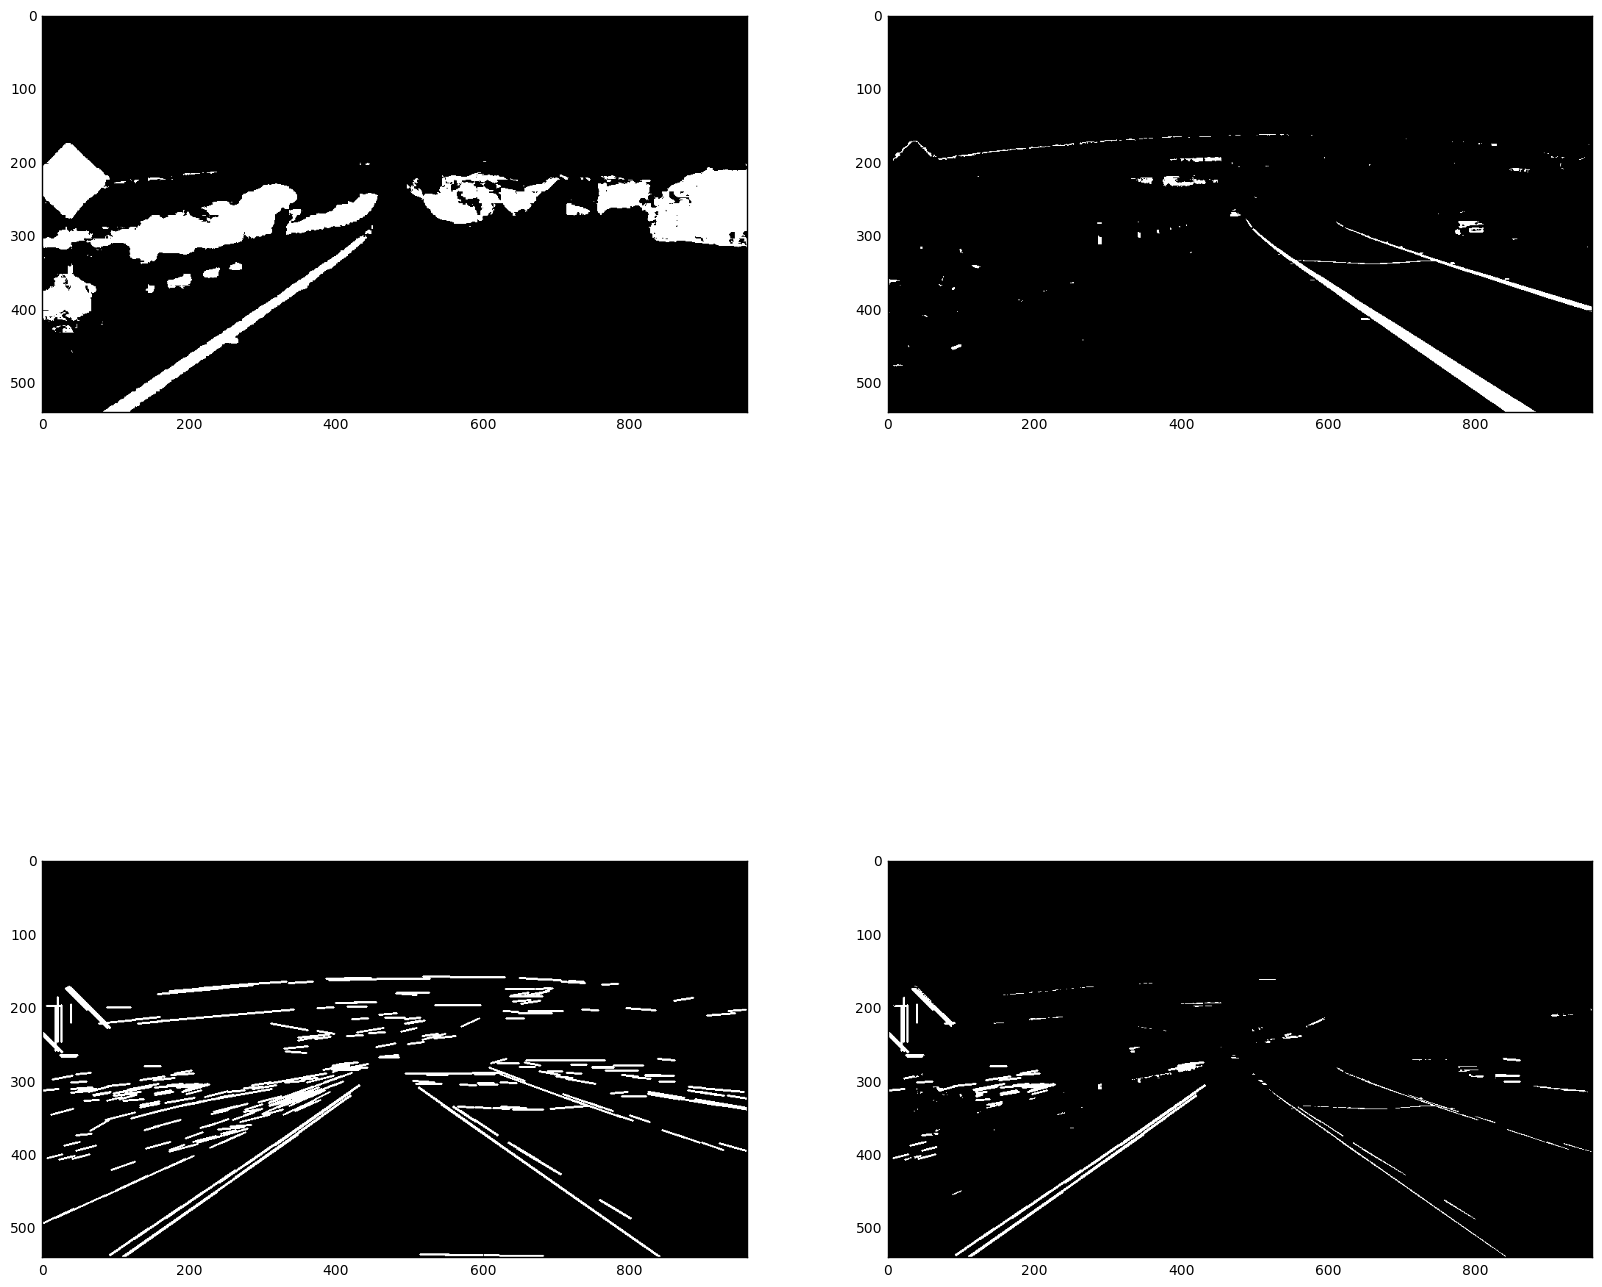

In [170]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1                       # 1 ~ 2
theta = 5 * np.pi/180         # 1 ~ 2
threshold = 40                # larger means more like a line
min_line_len = 20          # >=40 seems good
max_line_gap = 5             # <= 5 seems good
# I changed the dimension of line_image from M x N x 3 to M x N
# because I believe only the identified lines (left and right line of a lane)
# are necessary to be shown
line_image = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8) #creating a blank to draw lines on
lines = hough_lines(edges, rho, theta, threshold, min_line_len, max_line_gap)

# Run Hough on edge detected image
# Iterate over the output "lines" and draw lines on the blank
draw_lines(line_image, lines, color=[255, 0, 0], thickness=2)
#line_image=line_image[mask_yellow | mask_white]
masked_image = cv2.bitwise_and(line_image, mask_yellow | mask_white)
fig = plt.figure(figsize=(20, 20))
plt.subplot(2,2,1)
plt.imshow(mask_yellow,cmap='gray')
plt.subplot(2,2,2)
plt.imshow(mask_white,cmap='gray')
plt.subplot(2,2,3)
plt.imshow(line_image,cmap='gray')
plt.subplot(2,2,4)
plt.imshow(masked_image,cmap='gray')
"""
# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 
# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 

fig = plt.figure(figsize=(18, 18))
plt.subplot(1,3,1)
plt.imshow(color_edges)
plt.subplot(1,3,2)
plt.imshow(line_image)
plt.subplot(1,3,3)
plt.imshow(lines_edges)
"""

### Step 3.4 create a masked edges image using ROI 
By using cv2.fillPoly()

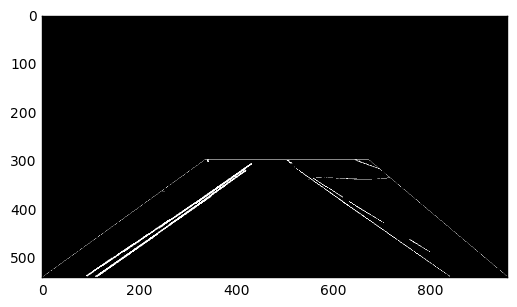

In [172]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   

# defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0.7*imshape[1],0.55*imshape[0]),(0.35*imshape[1], 0.55*imshape[0]), (0.*imshape[1], imshape[0]), (1.0*imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(masked_image, vertices)

# To have a better visualization, also draw the perimeter of ROI 
pts = vertices.reshape((-1,1,2))
cv2.polylines(masked_edges,[pts],True,(200,200,200))
plt.imshow(masked_edges,cmap='gray')
plt.show()


## Finding Lane Lines in a Video Stream
### Project Instructions

To get started on the project, download or <font color="red">git clone</font> [the project repository on GitHub](https://github.com/udacity/CarND-LaneLines-P1). You'll find the instructions in the README file. Click "Next" below to view information about setting up the project on your computer.

### Need to install opencv before testing the nodebook
conda install -c https://conda.binstar.org/menpo opencv3

In [16]:
import cv2 # import the opencv library

cv2.__version__ # this will print the version of your opencv2

'3.1.0'

### install ffmeg
### install imageio
conda install -c conda-forge imageio

In [18]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.win32.exe' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.win32.exe (27.4 MB)
Downloading: 8192/28781056 bytes (0.0%)114688/28781056 bytes (0.4%)303104/28781056 bytes (1.1%)589824/28781056 bytes (2.0%)942080/28781056 bytes (3.3%)1294336/28781056 bytes (4.5%)1671168/28781056 bytes (5.8%)2031616/28781056 bytes (7.1%)2424832/28781056 bytes (8.4%)2818048/28781056 bytes (9.8%)3186688/28781056 bytes (11.1%)3620864/28781056 bytes (12.6%)3940352/28781056 bytes (13.7%)4366336/28781056 bytes (15.2%)

In [19]:
import imageio
imageio.plugins.ffmpeg.download()

Does not work, look here: https://ffmpeg.zeranoe.com/builds/

Does not work, try this:
    pip install moviepy
Should be ok!

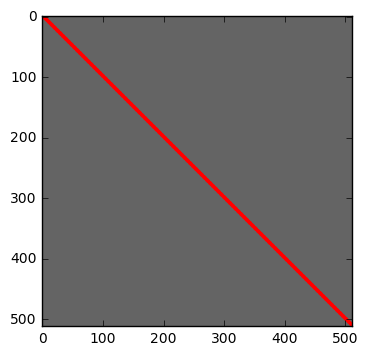

In [141]:
import numpy as np
import cv2

# Create a black image
img = np.ones((512,512,3), np.uint8)*100
# Draw a diagonal blue line with thickness of 5 px
cv2.line(img,(0,0),(511,511),(255,0,0),5)
plt.imshow(img)

## Prepare for the fitting of left/right lines

d:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


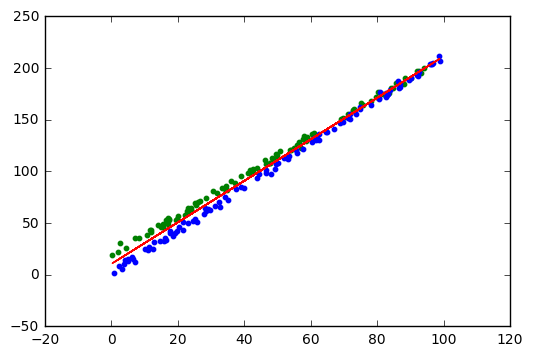

In [164]:
import matplotlib.pyplot as plt
import numpy as np

n = 100
noise=2 # max noise 
a1=1.9
b1=20
a2=2.1
b2=1.5

x1 = np.random.random(n)*100
y1 = a1*x1 + b1 + noise* np.random.randn(n)
x2 = np.random.random(n)*100
y2 = a2*x2 + b2 + noise* np.random.randn(n)

x=np.concatenate([x1, x2])
y=np.concatenate([y1, y2])

fig, ax = plt.subplots()
fit = np.polyfit(x, y, deg=1)
ax.plot(x, fit[0] * x + fit[1], color='red')
ax.scatter(x1, y1, s=10, color='g')
ax.scatter(x2, y2, s=10, color='b')
fig.show()